# 18.063 Matrix Calculus Pset 2 Solutions

MIT Department of Mathematics, January 2025.

In [1]:
using LinearAlgebra
relerr(a, b) = norm(a - b) / norm(b) # handy function to compute relative error

relerr (generic function with 1 method)

## Problem 2

First, let us define the function $g(x,p)$ from the problem set as Julia code, where `x` and `p` are arrays of length 2 and 3, respectively:

In [2]:
g(x, p) = [p[1]*x[1]^2 - x[2],
           x[1]*x[2] - p[2]*x[2] + p[3]]

g (generic function with 1 method)

For $p = [1,2,1]$ we should have an exact root for $x = [1,1]$.  Let's check:

In [3]:
p = [1,2,1]
g([1,1], p)

2-element Vector{Int64}:
 0
 0

### part 2.1

For part 3.1, you were asked to compute the Jacobian matrices $\frac{\partial g}{\partial x}$ and $\frac{\partial g}{\partial x}$ analytically.

We could use these as Julia functions for parts 3.2 and 3.3, so let's implement them here:

In [4]:
# ∂g/∂x:
gₓ(x, p) = [2p[1]*x[1]  -1
            x[2]        x[1]-p[2]]

# ∂g/∂p:
gₚ(x, p) = [x[1]^2  0     0
            0      -x[2]  1]

gₚ (generic function with 1 method)

#### Extra:

You were *not required* to do this, but for fun let's check our Jacobians against the Julia [ForwardDiff.jl AD package](https://github.com/JuliaDiff/ForwardDiff.jl) at some random point, with the help of the `relerr` function defined above:

In [5]:
using ForwardDiff

# random x and p
xr, pr = randn(2), randn(3)

relerr(gₓ(xr,pr), ForwardDiff.jacobian(x -> g(x,pr), xr)),
  relerr(gₚ(xr,pr), ForwardDiff.jacobian(p -> g(xr,p), pr))

(0.0, 0.0)

Hooray, the errors are ≈zero for both Jacobians!

### part 2.2

Here, we will implement a Newton iteration to solve $g(x) = 0$ for a given function $g$.

We could specialize it for our particular function $g(x,p)$ here, but it is even nicer to write a function that works in general: it takes an arbitrary function `g` as an argument, and uses ForwardDiff to comptue the Jacobian.  (This is an example of a [higher-order function](https://en.wikipedia.org/wiki/Higher-order_function).)

It stops after `n` iters or when a given relative tolerance `tol` in `x` is reached, whatever comes first.

We'll also print the value of the solution on each step so that we can watch the progress:

In [6]:
function newton(g, x; n=1000, tol=eps(float(one(eltype(x))))*10)
    for iteration = 1:n
        J = ForwardDiff.jacobian(g, x) # Jacobian at x by AD!
        
        δx = J \ g(x) # Newton step
        x = x - δx
        
        @show iteration, x
        
        # stop if ‖δx‖ ≤ tol ‖x‖:
        norm(δx) ≤ tol * norm(x) && break
    end
    return x
end
    

newton (generic function with 1 method)

Now, we will apply it to the function $g(x,p)$ that we are using here, with the suggested starting point of `x = [1.2, 1.3]`:

In [7]:
newton(x -> g(x, [1,2,1]), [1.2, 1.3])

(iteration, x) = (1, [0.9548387096774194, 0.8516129032258064])
(iteration, x) = (2, [0.9960065802133641, 0.9903343142638562])
(iteration, x) = (3, [0.9999776274777928, 0.9999394862397392])
(iteration, x) = (4, [0.9999999991467472, 0.9999999977930027])
(iteration, x) = (5, [1.0, 1.0])
(iteration, x) = (6, [1.0, 1.0])


2-element Vector{Float64}:
 1.0
 1.0

Hooray, it converged to $x = [1, 1]$ as desired, and to machine precision in **only 5 iterations**!

You can clearly see the number of digits roughly doubling in each step, which is known as "quadratic convergence".

### part 2.3

From the solutions, for $f(p) = \Vert x(p) \Vert$, we now want to compute 
$$
\nabla f = -\left(\frac{\partial g}{\partial p}\right)^T \left[ \underbrace{ \left(\frac{\partial g}{\partial x} \right)^{-T} \frac{x}{\Vert x \Vert}}_v \right] 
$$
at $p = [1,2,1]$ and the corresponding $x = [1,1]$.  Applying either our analytical Jacobians or the AD Jacobian, this is simply given by:

In [8]:
p = [1,2,1]
x = [1,1]

v = gₓ(x,p)' \ x / norm(x)  # adjoint solve (note ' = transpose)
∇f = -gₚ(x,p)' * v

3-element Vector{Float64}:
 -1.414213562373095
 -2.1213203435596424
  2.1213203435596424

This exactly matches the analytical answer from the solutions:

In [9]:
relerr(∇f, [-2,-3,3]/sqrt(2))

0.0

Now, let's compare it to a finite-difference approximation for a random small $\delta p$:

In [10]:
δp = randn(3) * 1e-8
δx = newton(x -> g(x, p+δp), x) - x

(iteration, x) = (1, [1.0000000033341496, 0.9999999980030572])
(iteration, x) = (2, [1.0000000033341498, 0.9999999980030573])


2-element Vector{Float64}:
  3.3341498451022744e-9
 -1.9969427222932268e-9

Not surprisingly, Newton converged almost immediately starting from $x = [1,1]$, since a small change in $p$ leads to a small change in $x$.  Now, let's compute the change in $f(x) = \Vert x \Vert$:

In [11]:
δf = norm(x + δx) - norm(x)

9.455483063192105e-10

and compare it to the derivative prediction $(\nabla f)^T \delta p$:

In [12]:
∇f'δp

9.455478730162042e-10

Hooray, they match very well!  More quantitatively, the relative difference is:

In [13]:
relerr(δf, ∇f'δp)

4.582560213379243e-7

i.e. they **match to almost 8 significant digits**, which makes it very unlikely that we have a bug in our calculation.   (The difference here is dominated by the error in the finite-difference calculation.)

#### Extra:

You were *not required* to do this, but for fun we can also use ForwardDiff.jl to compute $\nabla f$ by automatic differentiation.  It doesn't know that we are solving $g(x,p) = 0$ and does not use the implicit-function theorem — instead, it will simply propagate the chain rule through the Newton iteration.  But it should arrive at the same result:

In [14]:
 ad_∇f = ForwardDiff.gradient(p -> norm(newton(x -> g(x,p), x)), p)

(iteration, x) = (1, ForwardDiff.Dual{ForwardDiff.Tag{var"#10#12", Int64}, Float64, 3}[Dual{ForwardDiff.Tag{var"#10#12", Int64}}(1.0,-1.0,-1.0,1.0), Dual{ForwardDiff.Tag{var"#10#12", Int64}}(1.0,-1.0,-2.0,2.0)])


3-element Vector{Float64}:
 -1.414213562373095
 -2.1213203435596424
  2.1213203435596424

Yup, it matches our analytical result to machine precision!

In [15]:
relerr(ad_∇f, ∇f)

0.0

## Problem 4

To begin with, let's take the code from the example notebook shown in class (and posted on github):

In [16]:
using DifferentialEquations, Plots, ForwardDiff, StaticArrays, LaTeXStrings, LinearAlgebra

function doublependulum(u, params, t)
    g = 9.80665 # Earth gravity (m/s²)
    (; l1, l2, m1, m2) = params

    Δθ = u[1] - u[2]
    M = @SMatrix[l1*(m1+m2)   m2*l2*cos(Δθ)
                 l1*cos(Δθ)   l2]
    rhs = @SVector[-m2*l2*u[4]^2*sin(Δθ) - g*(m1+m2)*sin(u[1]),
                   l1*u[3]^2*sin(Δθ) - g*sin(u[2])]
    θ̈ = M \ rhs
    u̇ = @SVector[u[3], u[4], θ̈[1], θ̈[2]]
    return u̇
end

tspan = (0, 10);
p = (; l1=1, l2=1, m1=0.1, m2=0.1)

prob1 = ODEProblem(doublependulum, @SVector[2, 2.0, 0, 0], tspan, p)
sol1 = solve(prob1, reltol = 1e-10);

### part 4.2

Now, as discussed in the solutions part 4.1, we need to implement the following equations for the $4 \times 2$ Jacobian $J = \partial u/ \partial L$, where $L = [L_1, L_2]$:

$$
\frac{\partial J}{\partial t}  = \underbrace{\frac{\partial f}{\partial u}}{4\times 4} \underbrace{J}_{4\times 2} + \underbrace{\frac{\partial f}{\partial L}}_{4\times 2}
$$
with initial condition $J(0) = 0_{4\times 2}$.

As in the example from class, we'll use `ForwardDiff.jacobian(somefunction, v)` to compute $\partial f / \partial u$ and $\partial f / \partial L$ for us.  (Note that the input `v` to this function must be a vector, which we'll convert to/from the named-tuple `params`).  As in class, we'll integrate both $u$ and $J$ simultaneously, treating them as a vector of $4+4\times 2= 12$ parameters.

In [17]:
function doublependulum_∂L(uJ, params, t)
    # extract u and J from uJ
    u = SVector(ntuple(i -> uJ[i], Val(4)))
    J = reshape(SVector(ntuple(i -> uJ[i + 4], Val(8))), Size(4,2))    
    
    (; l1, l2, m1, m2) = params

    u̇ = doublependulum(u, params, t)
    J̇ = ForwardDiff.jacobian(u -> doublependulum(u, params, t), u) * J +
        ForwardDiff.jacobian(L -> doublependulum(u, (; l1=L[1], l2=L[2], m1, m2), t), @SVector[l1, l2])
    return [u̇; vec(J̇)]
end

prob_diff = ODEProblem(doublependulum_∂L, [@SVector[2, 2.0, 0, 0]; vec(@SMatrix zeros(4,2))], tspan, p)
sol_diff = solve(prob_diff, reltol = 1e-10);

Now, we were asked to plot $\partial \theta_2/\partial L_1$ and $\partial \theta_2/\partial L_2$ versus time.  These correspond to the **second row** of our $4 \times 2$ matrix $J$, or the **2nd and 6th** elements of $\mathrm{vec}(J)$, which are the **6th and 10th** elements of our combined solution `uJ = [u; vec(J)]`.

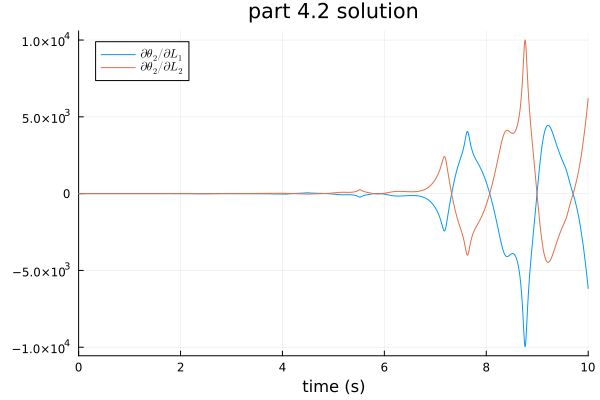

In [18]:
plot(sol_diff, idxs=[6,10], label=[L"\partial \theta_2/\partial L_1" L"\partial \theta_2/\partial L_2"])
plot!(xlabel="time (s)", title="part 4.2 solution")

As expected from the chaotic nature of the problem, they seem to grow exponentially.  We can check this on a log scale, which does indeed seem roughly linear (= exponential).

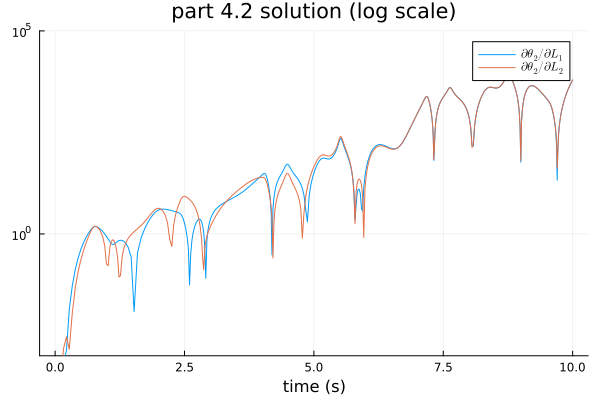

In [19]:
plot(sol_diff.t, abs.(sol_diff[6,:]) .+ 1e-20, label=L"\partial \theta_2/\partial L_1", yaxis=:log)
plot!(sol_diff.t, abs.(sol_diff[10,:]) .+ 1e-20, label=L"\partial \theta_2/\partial L_2", yaxis=:log)
plot!(xlabel="time (s)", title="part 4.2 solution (log scale)")

ylims!(1e-3,1e5)

### part 4.3

Now, let's check $\partial \theta_2 / \partial L_1$ at $t=1$ against finite differences, which just means re-solving with $L_1 + \delta L_1$ for some small $\delta L_1$ and verifying that $\delta \theta_2 \approx (\partial \theta_2 / \partial L_1) \delta L_1$.

Since we are only solving to `relerr = 1e-10` accuracy, we'll let $\delta L_1 = 10^{-5} L_1 = 10^{-5}$:

In [20]:
δL₁ = 1e-5
p = (; l1=1, l2=1, m1=0.1, m2=0.1)

δprob1 = ODEProblem(doublependulum, @SVector[2, 2.0, 0, 0], tspan, 
                    (; l1=1 + δL₁, l2=1, m1=0.1, m2=0.1))
δsol1 = solve(δprob1, reltol = 1e-10);

t = 1
δθ₂ = δsol1(t)[2] - sol1(t)[2]

8.460067905113888e-6

In [21]:
dθ₂ = sol_diff(t)[6] * δL₁

8.460048529167845e-6

Yay, **they match to 5 significant digits!**

In [22]:
relerr(δθ₂, dθ₂)

2.2902878129285016e-6

## Problem 6

Here, we need to compute the gradient of $f(A) = \det(A + \exp(A))$, and in the solutions we derived the formula:
$$
\nabla f = \det(X) (X^{-T} + \exp'(A^T)[X^{-T}]) \, ,
$$
where $X = A + \exp(A)$ and $\exp'$ is the derivative of a matrix exponential.  From pset~1, we also know that we can compute the derivative of a matrix exponential by
$$
\exp \begin{pmatrix} A & X \\ & A \end{pmatrix}
= \begin{pmatrix} \exp(A) & \exp'(A)[X] \\ & \exp(A) \end{pmatrix}
$$
(although there are other, more efficient algorithms).

So, we can implement this function and its gradient as follows:

In [23]:
using LinearAlgebra

f₄(A) = det(A + exp(A))
    
function ∇f₄(A)
    m = LinearAlgebra.checksquare(A)
    X = A + exp(A)
    X⁻ᵀ = inv(X')
    exp′ = exp([A' X⁻ᵀ; 0I A'])[1:m,m+1:end] # exp′(Aᵀ)[X⁻ᵀ]
    return det(X) * (X⁻ᵀ + exp′)
end

∇f₄ (generic function with 1 method)

Now, let's check it against finite differences for random 5×5 matrices:

In [24]:
A = randn(5,5)
δA = randn(5,5) * 1e-8

δf₄ = f₄(A + δA) - f₄(A) # finite difference

3.3721836842914854e-6

In [25]:
dot(∇f₄(A), δA) # Frobenius inner product

3.3721837737408912e-6

Hooray, they clearly match pretty well!

More quantitatively, we can compute the relative error using the `relerr` function we defined above:

In [26]:
relerr(δf₄, dot(∇f₄(A), δA))

2.652566165748485e-8

It matches to **more than 7 digits**, which is about as much as we can hope for from our finite-difference approximation.   This is a pretty strong indication that we computed $\nabla f$ correctly.

#### Extra:

For fun, we could also try automatic differentiation.

Unfortunately, ForwardDiff.jl currently doesn't know how to differentiate through a matrix exponential:

In [27]:
ForwardDiff.gradient(f₄, A)

LoadError: MethodError: no method matching exp!(::Matrix{ForwardDiff.Dual{ForwardDiff.Tag{typeof(f₄), Float64}, Float64, 9}})
The function `exp!` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  exp!([91m::StridedMatrix{T}[39m) where T<:Union{Float32, Float64, ComplexF64, ComplexF32}
[0m[90m   @[39m [35mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.11.2+0.x64.apple.darwin14/share/julia/stdlib/v1.11/LinearAlgebra/src/[39m[90m[4mdense.jl:677[24m[39m


Also, in any case, forward-mode AD is a dubious idea for computing matrix gradients, or any gradients with lots of components.  You probably want to use reverse-mode AD.

We can try the [Zygote.jl](https://github.com/FluxML/Zygote.jl) reverse-mode AD package in Julia, which knows how to differentiate matrix exponentials via the [ChainRules.jl](https://github.com/JuliaDiff/ChainRules.jl) package, which uses an algorithm by [Al-Mohy and Higham (2009)](https://epubs.siam.org/doi/10.1137/080716426):

In [28]:
import Zygote
Zygote.gradient(f₄, A)[1]

5×5 Matrix{Float64}:
 -71.5328    78.0398    6.51264   30.525   -106.685
   8.96498   34.5902   27.6976    14.097    -74.3997
  -4.06586  -31.2296  -68.4742    37.9627    45.4109
 -33.0465   -76.229     1.37258  -46.4313    85.4522
 -43.5903    32.9089   -9.23788   38.231      1.20525

Hooray, at least it gives us *something*.  Let's check that it matches our answer:

In [29]:
relerr(Zygote.gradient(f₄, A)[1], ∇f₄(A))

5.240276932341422e-16

Hooray, it matches our result to nearly machine precision!